In [1]:
#! pip install pandas
#! pip install pyarrow
#! pip install requests
# ! pip install matplotlib
# ! pip install seaborn
# ! pip install opencv-python

In [1]:
%matplotlib inline

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import ast
import numpy as np
import os
import re
from pathlib import Path
import json
import matplotlib.pyplot as plt
import cv2
from typing import List, Dict, Optional, Union, Any
import ast
import seaborn as sns
import math
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy


In [2]:
ROOT_DIR = Path.cwd()


# Filter the dataframe such that each entry contains the images 

In [ ]:

parquet_file = pq.ParquetFile(r"data/food.parquet")
num_row_groups = parquet_file.num_row_groups
batch_size = 10000
code_threshold = 5000
chunks = []
imageval = 0
for batch in parquet_file.iter_batches(batch_size=batch_size):
    df_chunk = pd.DataFrame(batch.to_pandas())
    df_chunk["images"] = df_chunk["images"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df_chunk = df_chunk[df_chunk["images"].apply(lambda x: len(x) > 0 if isinstance(x, (list, np.ndarray)) else False)]
    imageval += len(df_chunk)
    chunks.append(df_chunk)
    if imageval >= code_threshold:
        break
final_df = pd.concat(chunks, ignore_index=True)
print(f"Final DataFrame shape : {final_df.shape}")
final_df.to_csv(r"data/df_withimages.csv")

Final DataFrame shape : (7672, 110)


In [4]:
columns_to_consider=["code","brands","brands","product_quantity_unit", "categories","categories_properties", "compared_to_category", "food_groups_tags", "nutriments", "nutriscore_grade", "nutriscore_score", "nutrient_levels_tags", "labels", "allergens_tags", "additives_n", "additives_tags", "ingredients", "ingredients_text", "ingredients_analysis_tags", "ecoscore_grade", "ecoscore_score", "states_tags", "complete"]
filtered_df=final_df.loc[:, columns_to_consider]
filtered_df.shape


(7672, 23)

In [5]:
filt_val_cnt=filtered_df["categories"].value_counts()
print(filt_val_cnt.index[:20])
print(filt_val_cnt.values[:20])

Index(['undefined', '', 'null', 'Snacks',
       'Plant-based foods and beverages, Beverages, Plant-based beverages',
       'Desserts, Frozen foods, Frozen desserts',
       'Snacks, Sweet snacks, Biscuits and cakes, Biscuits',
       'Condiments, Sauces, Groceries',
       'Snacks, Sweet snacks, Confectioneries',
       'Dairies, Fermented foods, Fermented milk products, Cheeses',
       'Condiments, Groceries',
       'Plant-based foods and beverages, Plant-based foods, Breakfasts, Cereals and potatoes, Cereals and their products, Breakfast cereals',
       'Plant-based foods and beverages, Plant-based foods, Cereals and potatoes, Cereals and their products, Pastas',
       'Snacks, Sweet snacks, Confectioneries, Candies',
       'Snacks, Salty snacks, Appetizers, Chips and fries, Crisps, Corn chips',
       'Plant-based foods and beverages, Plant-based foods, Cereals and potatoes, Breads',
       'Plant-based foods and beverages, Dairy substitutes, Milk substitutes, Creamer',
     

### What are the different categories of food items available in the dataset

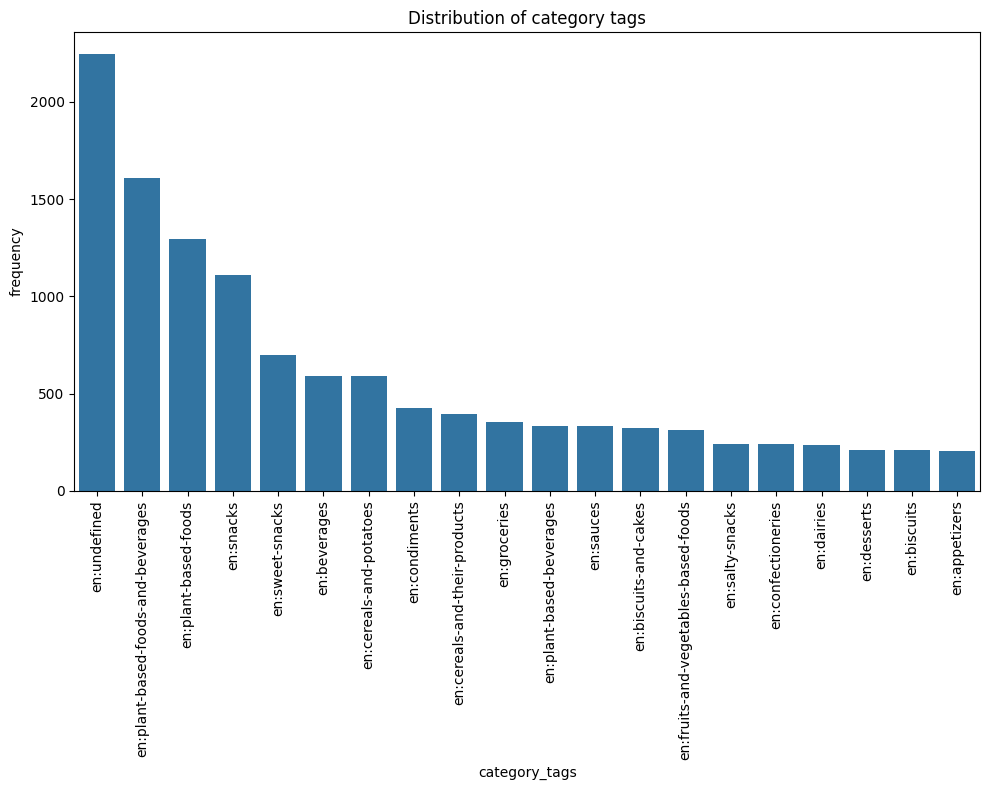

In [ ]:

final_df_cp = copy.deepcopy(final_df)
unique_values = final_df["categories_tags"].unique
value_counts = final_df["categories_tags"].value_counts()

final_df_cp["categories_tags"] = final_df_cp["categories_tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

categories_counts={}
for ind, row in final_df_cp.iterrows():
    try:
        if len(row["categories_tags"]) > 0:
            for item in row["categories_tags"]: 
                if item not in categories_counts.keys():
                    categories_counts.update({item: 0})
                else:
                    categories_counts[item]+=1
    except:
        pass
sorted_dict = dict(sorted(categories_counts.items(), key=lambda item: item[1], reverse=True))
category_tags=list(sorted_dict.keys())[:20]
category_tags_cnts = list(sorted_dict.values())[:20]
plt.figure(figsize=(10,8))
sns.barplot(x=category_tags,y=category_tags_cnts)
plt.xticks(rotation=90)
plt.xlabel("category_tags")
plt.ylabel("frequency")
plt.title("Distribution of category tags")
plt.tight_layout()
plt.show()




### Category based Nutriment distribution - How does the Nutriment distribution vary for each category

In [7]:
class category_class:
    """Class for specific categories
    """
    def __init__(self, input_df: pd.DataFrame):
        self.input_df = input_df
        self.merged_df = copy.deepcopy(self.input_df)
        self.nutriment_df, nutricomb_df, self.nutr_cols=self.create_expfeat_column("nutriments","name","100g",cols_to_drop=True)
        self.ingredients_df, ingrecomb_df, self.ingr_cols=self.create_expfeat_column("ingredients","id","percent_estimate",cols_to_drop=False)
        self.nutri_ingr_all_df = pd.merge(nutricomb_df.loc[:, ~nutricomb_df.columns.duplicated()], 
                                      ingrecomb_df.loc[:, ~ingrecomb_df.columns.duplicated()], on='code', how='inner')
        self.nutri_ingr_df = pd.concat([self.nutriment_df, self.ingredients_df], axis=1)
        self.ingredients_df_mask = self.ingredients_df[self.ingr_cols].gt(0).astype(int)
        self.nutrients_ingredients_mask_df = pd.concat([self.nutriment_df, self.ingredients_df_mask], axis=1)
        self.top5ingr_nutr_dict=self.top5ingredient_per_nutriment(plot=False)
        

    def get_col_name(self, column_name: Union[str,List[str]], indexno: int = 0) -> pd.Series:
        """get specific column data for each index

        Args:
            column_name (_type_): _description_
            indexno (int, optional): _description_. Defaults to 0.

        Returns:
            pd.Series: _description_
        """
        return self.input_df.loc[indexno, column_name]

    def plotspecific_codeimage(self, index_no: int):
        """plotimage of each code based on the index (only compatible images)

        Args:
            filtered_images (_type_): _description_
            image_path (_type_): _description_
        """
        prefix = str(self.get_col_name("code", index_no))
        image_path = ROOT_DIR / "data" / "images"
        matching_files = [f for f in os.listdir(image_path) if f.startswith(prefix)]
        filtered_images = [f for f in matching_files if not re.search(r'_\d+\.0\.jpg$', f)] # remove invalid images
        n_images = len(filtered_images)
        for i, file in enumerate(filtered_images):
            image = cv2.imread(image_path / file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.subplot(1, n_images, i+1)
            plt.imshow(image)
            plt.title(file, fontsize = 8)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    def indexbasednutrimentsimageinfo(self, indexno: int = 0) -> None:
        """Filter out information corresponding to specific information from a dataframe for an index

        Args:
            indexno (int, optional): _description_. Defaults to 0.
        """
        
        if self.get_col_name("ingredients", indexno):
            print("**********rawingredients*********")
            x = self.get_col_name("ingredients_text", indexno)

            for k in range(len(x)): print(x)
            print("********************************")
            print("**********structingredients********")
            z=json.loads(self.get_col_name("ingredients", indexno))
            for ele in z:
                print(ele)
            print("********************************")
            print(self.get_col_name("categories", indexno))
            print(x for x in self.get_col_name("nutriments", indexno))
            print(self.get_col_name("nutriments", indexno))
            print(self.get_col_name("code", indexno))
            self.plotspecific_codeimage(indexno)
        else:
            print("not valid ingredients for index")

    def colcontentstodict(self, cont: Union[list, np.ndarray], k: str=None, v:str = None) -> Dict[str, Any]:
        """Convert Columns to dictionary

        Args:
            cont (_type_): _description_

        Returns:
            Dict[str, Any]: _description_
        """
        if cont is None:
            return {}
        if not isinstance(cont, (list, np.ndarray)):
            return {}
        out = {}
        for item in cont:
            try:
                name = item.get(k)
                value = item.get(v)
                if name:
                    out[name]=value
            except Exception as e:
                print(f"error {e}")
                continue
        return out
    
   
    def create_expfeat_column(self, column_name: str="nutriments", k:str="name", v:str="100g", cols_to_drop=False) -> None:
        """Create separate column for each nutriment and associated value

        Args:
            column_name (_type_): _description_
        """
        self.input_df = self.input_df.reset_index(drop=True)
        self.input_df[column_name] = self.input_df[column_name].apply(lambda x: json.loads(x) if isinstance(x, str) else x if x is not None else [])
        self.input_df[f"{column_name}_Dict"] = self.input_df[column_name].apply(lambda x: self.colcontentstodict(x,k,v))
        column_df = pd.json_normalize(self.input_df[f"{column_name}_Dict"]).fillna(0)
        cols_list = column_df.columns
        if cols_to_drop:
            cols_to_drop = [col for col in cols_list if (column_df[col] !=0).mean() < 0.1]
            column_df.drop(columns=cols_to_drop, inplace=True)
            cols_list = column_df.columns
        merged_df = pd.concat([self.input_df.drop(columns=[f"{column_name}_Dict"]), self.input_df], axis=1)
        return column_df, merged_df, cols_list

    def getboxplot(self, colname):
        if colname == "nutriments":
            self.plot_box(self.nutriment_df)
        elif colname == "ingredients":
            self.plot_box(self.ingredients_df)


    def plot_box(self, inp_df: pd.DataFrame):
        """box plot for each nutriments for selected category(ies)

        Args:
            inp_df (_type_): _description_
        """
        cols_list=inp_df.columns
        cols_list_cnt = max(len(cols_list.tolist()), 12)
        n_cols  = 3
        n_rows = math.ceil(cols_list_cnt/ n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
        axes = axes.flatten()
        for i, col in enumerate(cols_list):
            axes[i].boxplot(inp_df[col], vert=True, patch_artist=True, showfliers=False)
            axes[i].set_title(f"{col} - sk: {inp_df[col].skew().round(1)}, krt : {inp_df[col].kurtosis().round(1)}")
            axes[i].set_ylabel('Value')
            axes[i].set_xlabel('')
        plt.tight_layout()
        plt.show()

    def plot_ingredient_dist_pernutr(self):
        n_cols = 5
        total_plots = sum(len(top5) for top5 in self.top5ingr_nutr_dict.values())
        n_rows = math.ceil(total_plots / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
        axes = axes.flatten()

        plot_idx = 0  
        
        for nutr, top5 in self.top5ingr_nutr_dict.items():
            ingr_list = top5.index.tolist()
            nutr_Df=self.nutri_ingr_df[self.nutri_ingr_df["proteins"] > 0.0]
            for ingr in ingr_list:
                if plot_idx >= len(axes):
                    continue  
                axes[plot_idx].boxplot(nutr_Df[ingr].dropna(), 
                                    vert=True, patch_artist=True, showfliers=False)
                axes[plot_idx].set_title(f"{nutr}: {ingr}", fontsize=10)
                axes[plot_idx].set_ylabel('Value')
                axes[plot_idx].set_xlabel('')
                axes[plot_idx].autoscale()
                plot_idx += 1

        fig.suptitle("Top 5 Ingredients Impacting Each Nutrient", fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
        plt.show()


    def top5ingredient_per_nutriment(self, plot=False) -> Dict:
        top5dict = {}
        for nutrient in self.nutr_cols:
            correlations = self.nutrients_ingredients_mask_df[self.ingr_cols.to_list() + [nutrient]].corr()[nutrient]
            correlations = correlations.drop(nutrient)
            top_5 = correlations.abs().sort_values(ascending=False).head(5)
            top5dict[nutrient] = top_5
        if plot:
            itemslist = max(len(top5dict.keys()), 12)
            n_cols  = 3
            n_rows = math.ceil(itemslist/ n_cols)
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
            axes = axes.flatten()
            for ax, (nut, top5) in zip(axes, top5dict.items()):
                top5.plot(kind="bar", color = "skyblue", edgecolor = "black", ax=ax)
                ax.set_title(f"top5 ingred on {nut}", fontsize=14)
                ax.set_ylabel("correlation")
                ax.set_xlabel("Ingredient")
                ax.grid(axis='y', linestyle='--', alpha=0.7)
                ax.set_xticklabels(top5.index, rotation=45, ha='right')

            plt.tight_layout()
            plt.show()
        return top5dict

In [15]:
selected_categories= ["en:plant-based-food-and-bevarages", "en:beverages", "en:plant-based-foods"]
selected_categories = ["en:snacks"]
keywords = selected_categories
df_snacks = final_df_cp[final_df_cp["categories_tags"].apply(lambda tags: tags is not None and any(kw in tags for kw in keywords))]
df_snacks.reset_index(inplace=True)
cat_class=category_class(df_snacks)



In [13]:
df_snacks.loc[13,"additives_tags"]
df_snacks.loc[13, "ingredients"]

'[{"percent_max":86.8,"percent_min":7.6923076923076925,"is_in_taxonomy":1,"percent_estimate":47.246153846153845,"vegan":"yes","id":"en:water","text":"eau","vegetarian":"yes","ciqual_food_code":"18066","percent":null,"from_palm_oil":null,"ingredients":null,"ecobalyse_code":"36b3ffec-51e7-4e26-b1b5-7d52554e0aa6","processing":null,"labels":null,"origins":null,"ecobalyse_proxy_code":null,"quantity":null,"quantity_g":null,"ciqual_proxy_food_code":null},{"percent_max":45.05,"percent_min":3.3,"is_in_taxonomy":1,"percent_estimate":24.174999999999997,"vegan":"yes","id":"en:corn-starch","text":"amidon de maïs","vegetarian":"yes","ciqual_food_code":"9510","percent":null,"from_palm_oil":null,"ingredients":null,"ecobalyse_code":null,"processing":null,"labels":null,"origins":null,"ecobalyse_proxy_code":null,"quantity":null,"quantity_g":null,"ciqual_proxy_food_code":null},{"percent_max":31.133333333333336,"percent_min":3.3,"is_in_taxonomy":1,"percent_estimate":15.93942307692308,"vegan":"yes","id":"en

In [14]:
print(cat_class.get_col_name("categories_properties", indexno=90))
print(cat_class.get_col_name("categories", indexno=90))
print(cat_class.get_col_name("additives_tags", indexno=90))
print(cat_class.get_col_name("ingredients", indexno=90))


{'ciqual_food_code': 25969.0, 'agribalyse_food_code': None, 'agribalyse_proxy_food_code': 25903.0}
Aliments et boissons à base de végétaux, Aliments d'origine végétale, Aliments à base de fruits et de légumes, Plats préparés, Soupes, Soupes de légumes
None
[]


Index(['salt', 'energy', 'sugars', 'proteins', 'carbohydrates', 'sodium',
       'saturated-fat', 'fat', 'energy-kcal', 'nutrition-score-fr',
       'fruits-vegetables-legumes-estimate-from-ingredients', 'fiber',
       'fruits-vegetables-nuts-estimate-from-ingredients', 'nova-group',
       'calcium', 'vitamin-a', 'vitamin-c', 'iron', 'monounsaturated-fat',
       'polyunsaturated-fat', 'potassium', 'vitamin-b1', 'vitamin-pp',
       'vitamin-b2'],
      dtype='object')


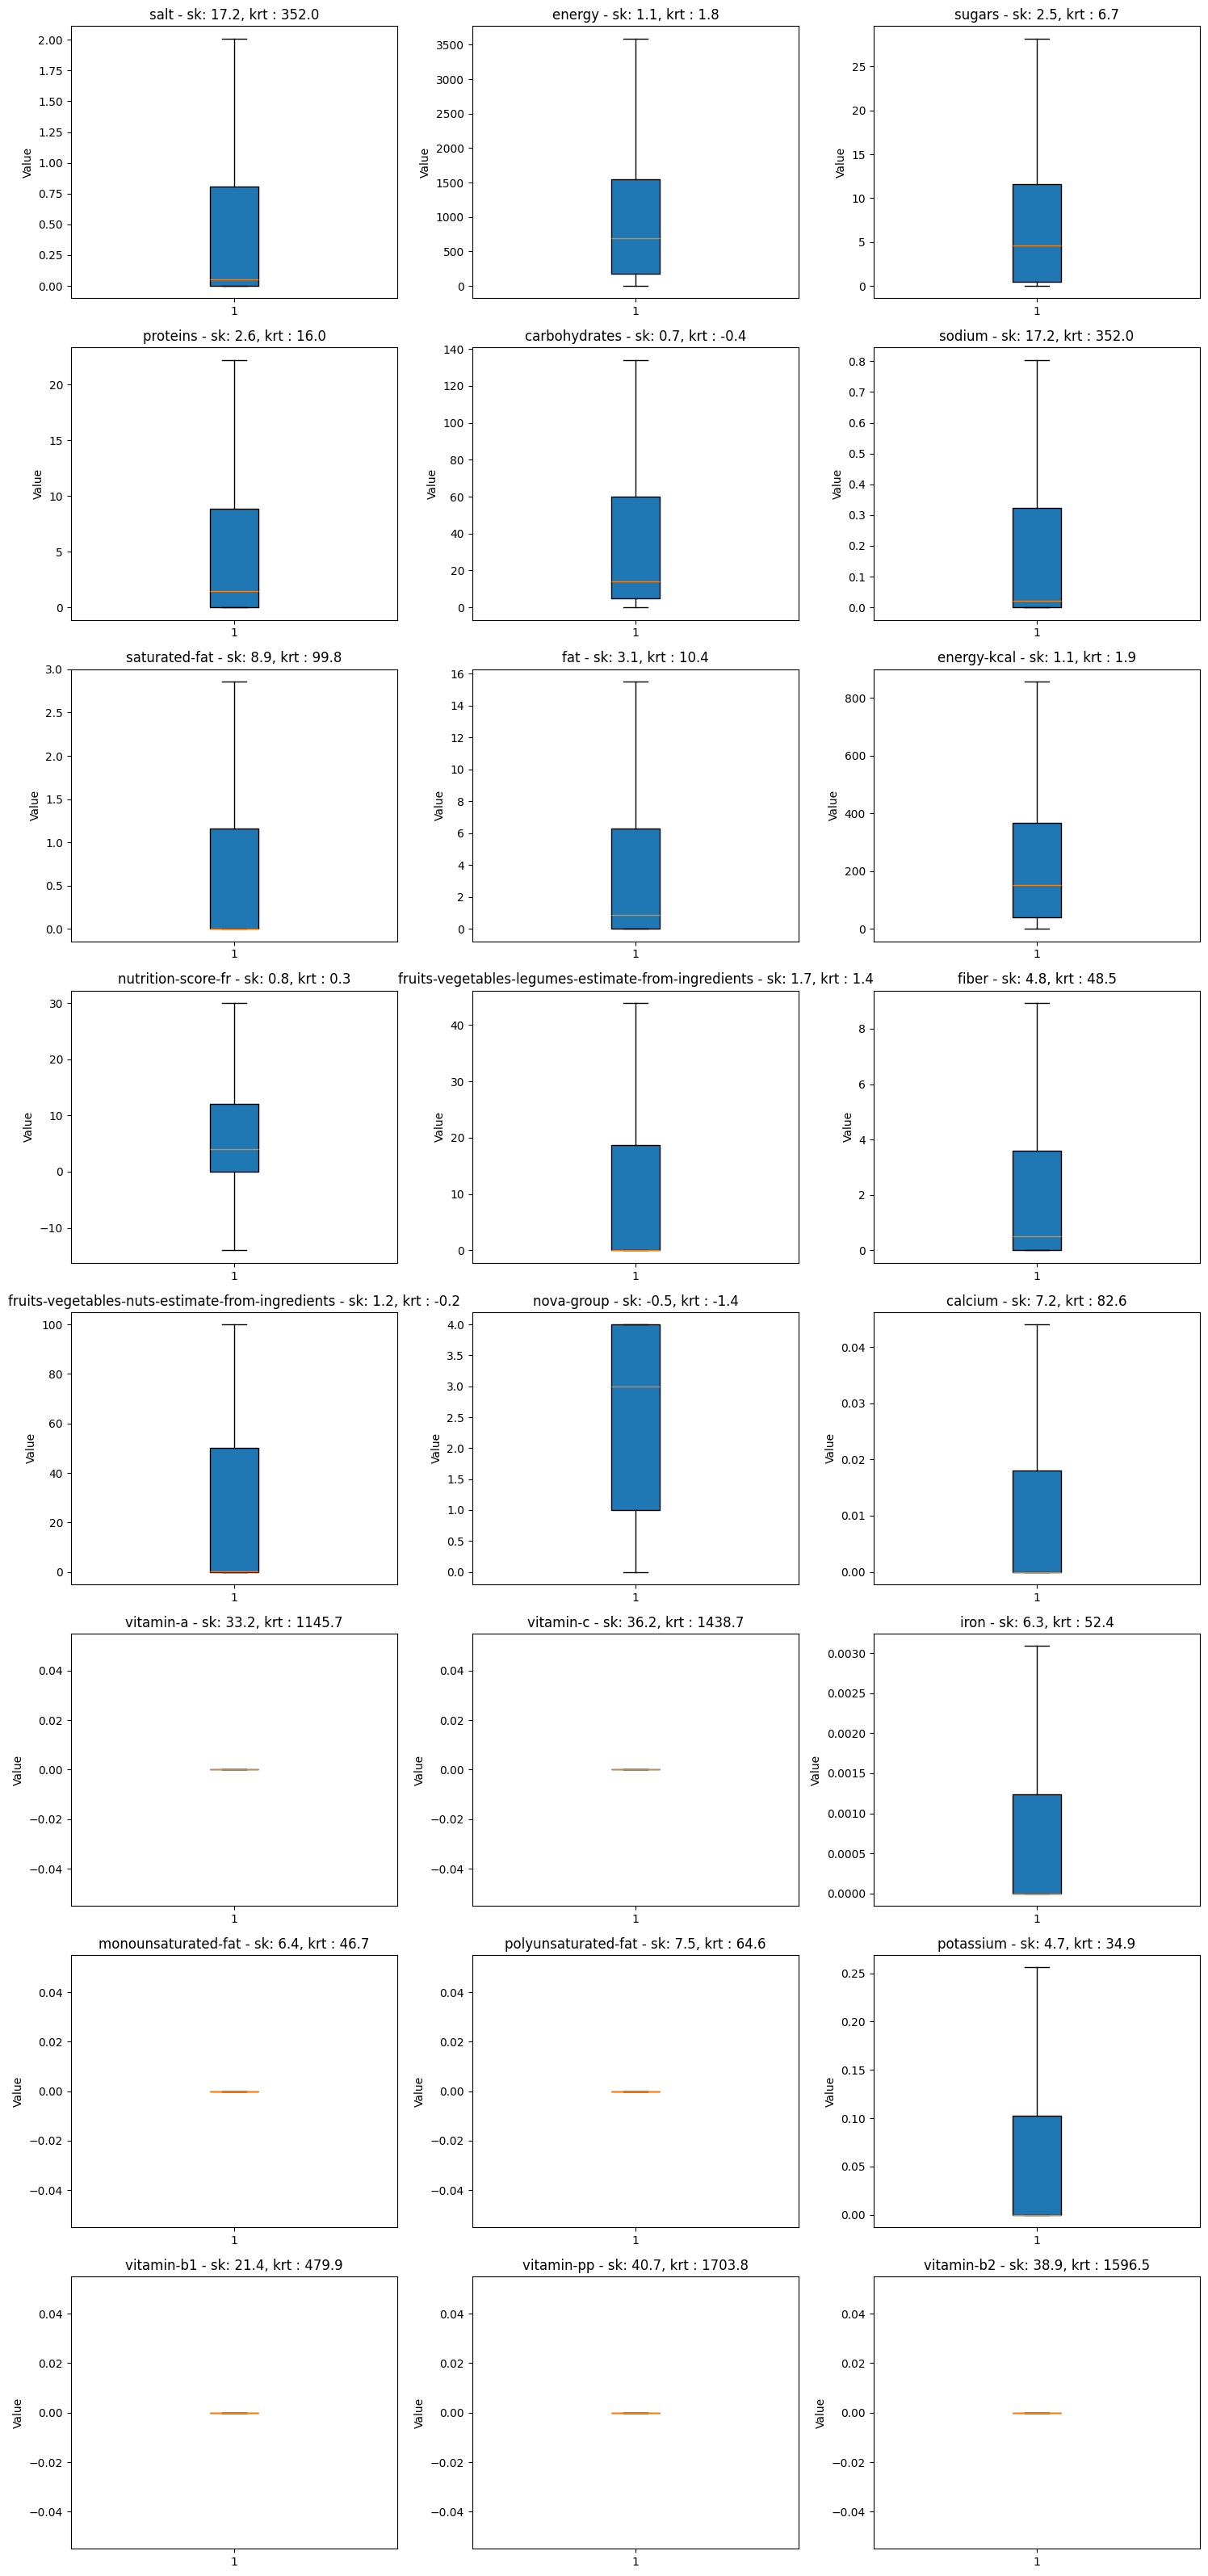

In [63]:
print(cat_class.nutriment_df.columns)
cat_class.getboxplot("nutriments")

In [11]:
_=cat_class.top5ingredient_per_nutriment(plot=False)

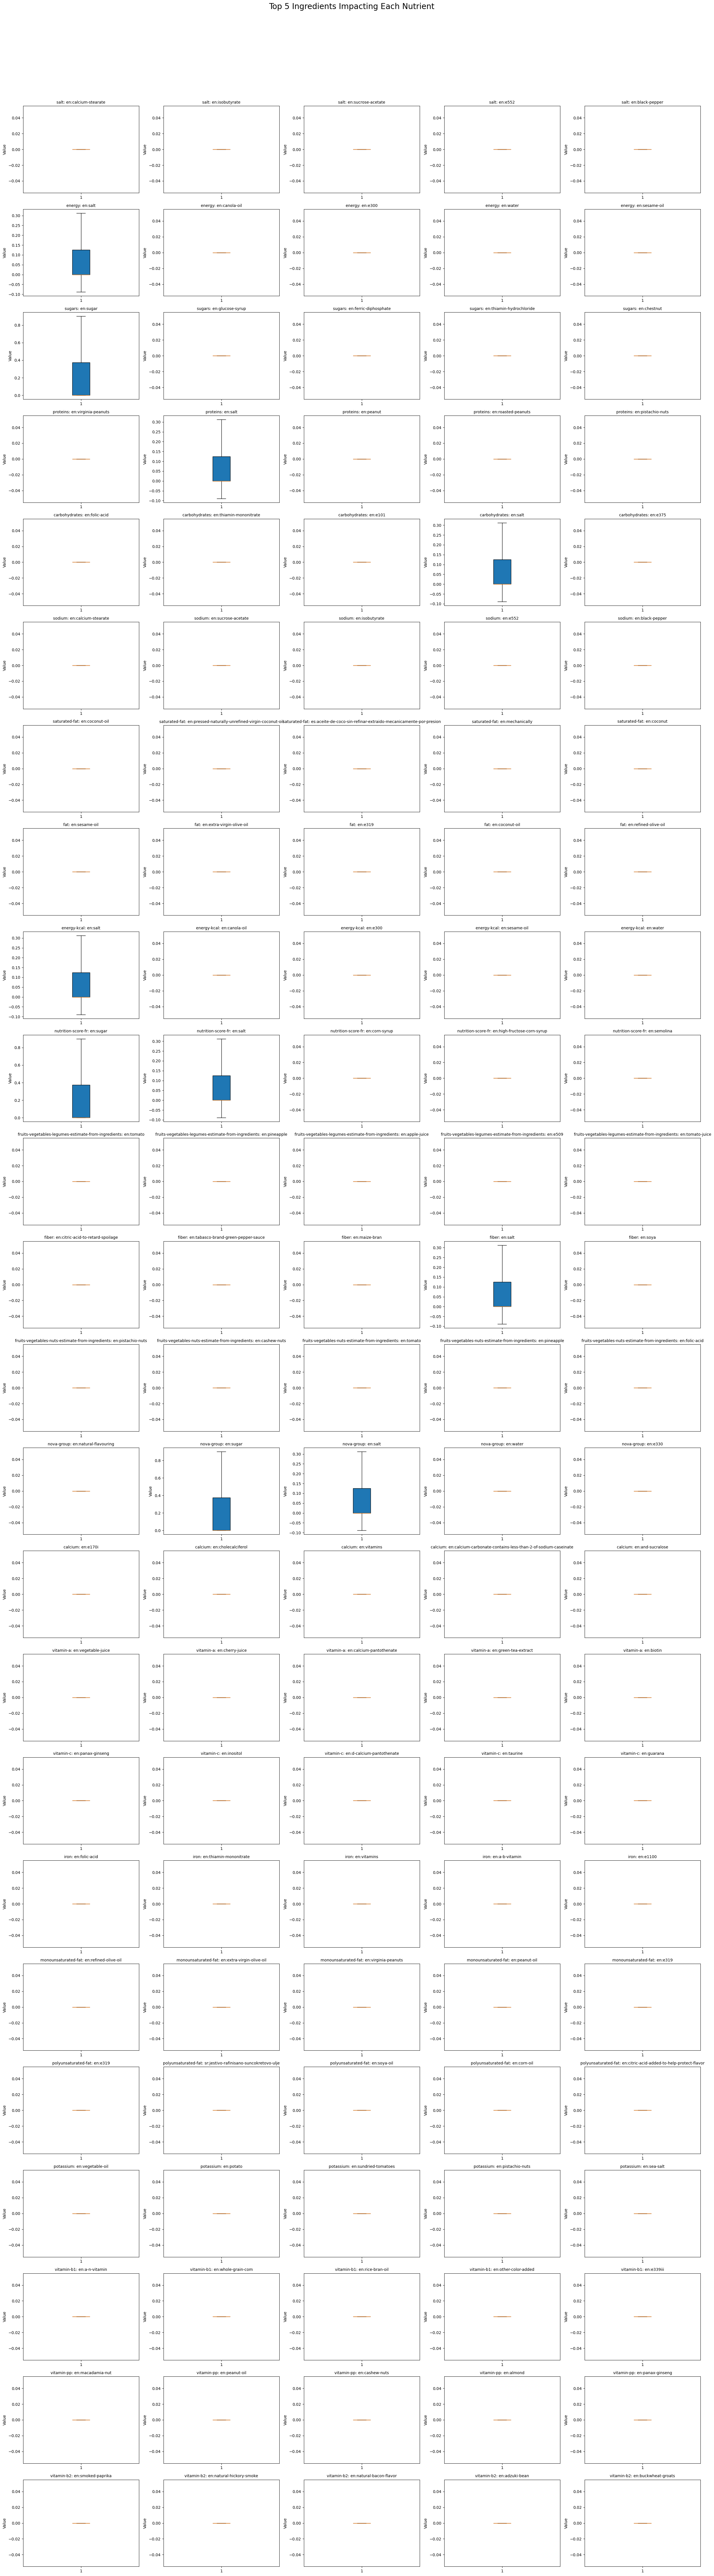

In [12]:
cat_class.plot_ingredient_dist_pernutr()

Index(['proteins', 'salt', 'sodium', 'saturated-fat', 'fat', 'energy-kcal',
       'nutrition-score-fr', 'carbohydrates', 'energy', 'sugars', 'fiber',
       'fruits-vegetables-nuts-estimate-from-ingredients', 'nova-group'],
      dtype='object')

#####  'saturated fat + sugar + fiber' is long tailed (right skewed). 


### Print the ingredient structure

C:\Users\praar\AppData\Local\Temp\ipykernel_22404\1207182076.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pprint.pprint(cat_class.get_col_name(["ingredients_text", "ingredients_analysis_tags", "ingredients", "ingredients_tags"],index_no)[2])


('[{"percent_max":100.0,"percent_min":9.090909090909092,"is_in_taxonomy":1,"percent_estimate":54.54545454545455,"vegan":"yes","id":"en:sugar","text":"sugar","vegetarian":"yes","ciqual_food_code":null,"percent":null,"from_palm_oil":null,"ingredients":null,"ecobalyse_code":"8f075c25-9ebf-430c-b41d-51d165c6e0d8","processing":null,"labels":null,"origins":null,"ecobalyse_proxy_code":null,"quantity":null,"quantity_g":null,"ciqual_proxy_food_code":"31016"},{"percent_max":50.0,"percent_min":0.0,"is_in_taxonomy":1,"percent_estimate":22.727272727272727,"vegan":"yes","id":"en:corn-syrup","text":"corn '
 'syrup","vegetarian":"yes","ciqual_food_code":null,"percent":null,"from_palm_oil":null,"ingredients":null,"ecobalyse_code":null,"processing":null,"labels":null,"origins":null,"ecobalyse_proxy_code":null,"quantity":null,"quantity_g":null,"ciqual_proxy_food_code":"31089"},{"percent_max":33.333333333333336,"percent_min":0.0,"is_in_taxonomy":1,"percent_estimate":11.36363636363636,"vegan":"yes","id":"e

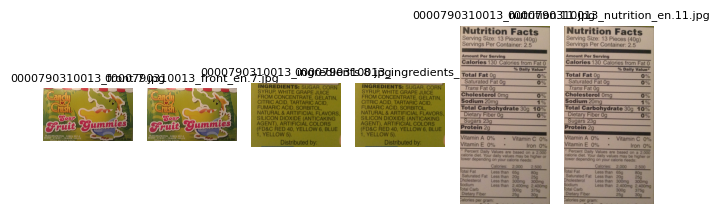

In [153]:
# For each row index get the values printed along with the available image plot
index_no=10
pprint.pprint(cat_class.get_col_name(["ingredients_text", "ingredients_analysis_tags", "ingredients", "ingredients_tags"],index_no)[2])
# pprint.pprint(cat_class.get_col_name("nutriments",index_no))

cat_class.plotspecific_codeimage(index_no)

### Distribution ingredients against different Nutriments for a given category 


### Get distribution of nutriments across Plant based foods

In [57]:
filtered_df[filtered_df["categories"]=="Dairy"]

,code,brands,brands,product_quantity_unit,categories,categories_properties,compared_to_category,food_groups_tags,nutriments,nutriscore_grade,...,allergens_tags,additives_n,additives_tags,ingredients,ingredients_text,ingredients_analysis_tags,ecoscore_grade,ecoscore_score,states_tags,complete
1,0000111301201,Canola Harvest,Canola Harvest,g,Dairy,"{'ciqual_food_code': None, 'agribalyse_food_co...",en:dairies,[],"[{'name': 'trans-fat', 'value': 0.0, '100g': 0...",e,...,"[en:milk, en:soybeans]",4.0,"[en:e202, en:e322, en:e322i, en:e330, en:e471]","[{""percent_max"":100.0,""percent_min"":6.66666666...","[{'lang': 'main', 'text': 'CANOLA OIL, WATER, ...","[en:palm-oil, en:non-vegan, en:vegetarian-stat...",None,NaN,"[en:to-be-completed, en:nutrition-facts-comple...",0


## Create new columns based on category tags

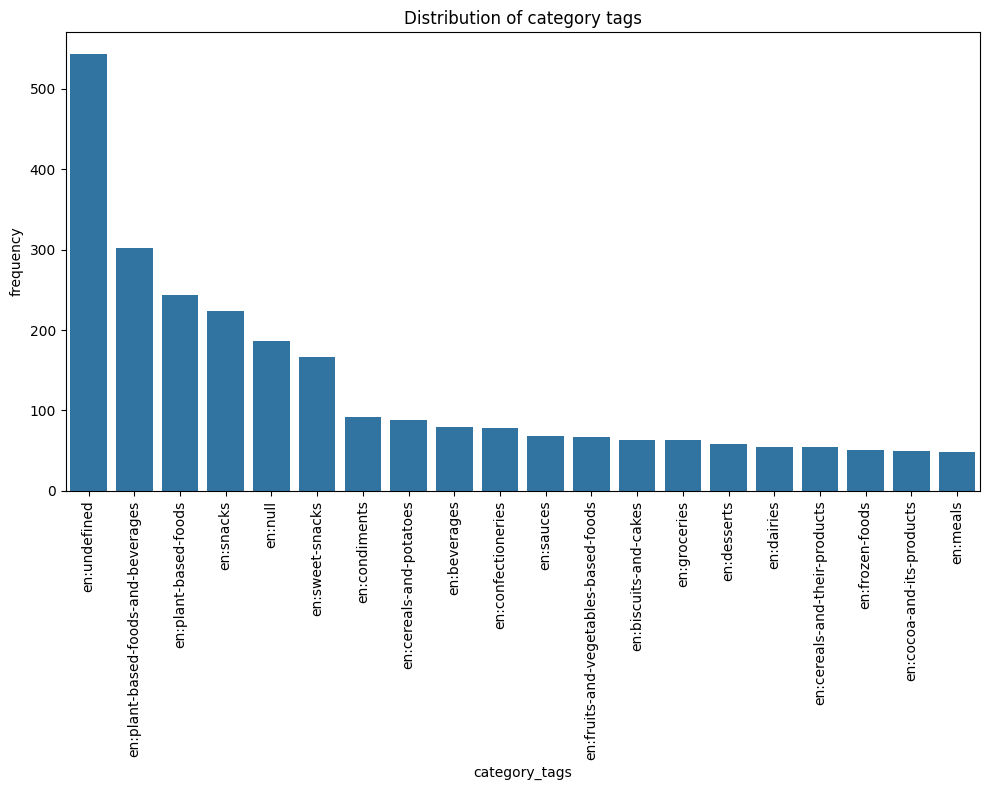

## How many of the above categories have good number of images

['en:milk', 'en:gluten', 'en:soybeans', 'en:nuts', 'en:peanuts', 'en:pork', 'en:celery', 'en:mustard', 'en:sesame-seeds', 'en:fish']
[180  79  60  34  14  14  13  13   9   8]


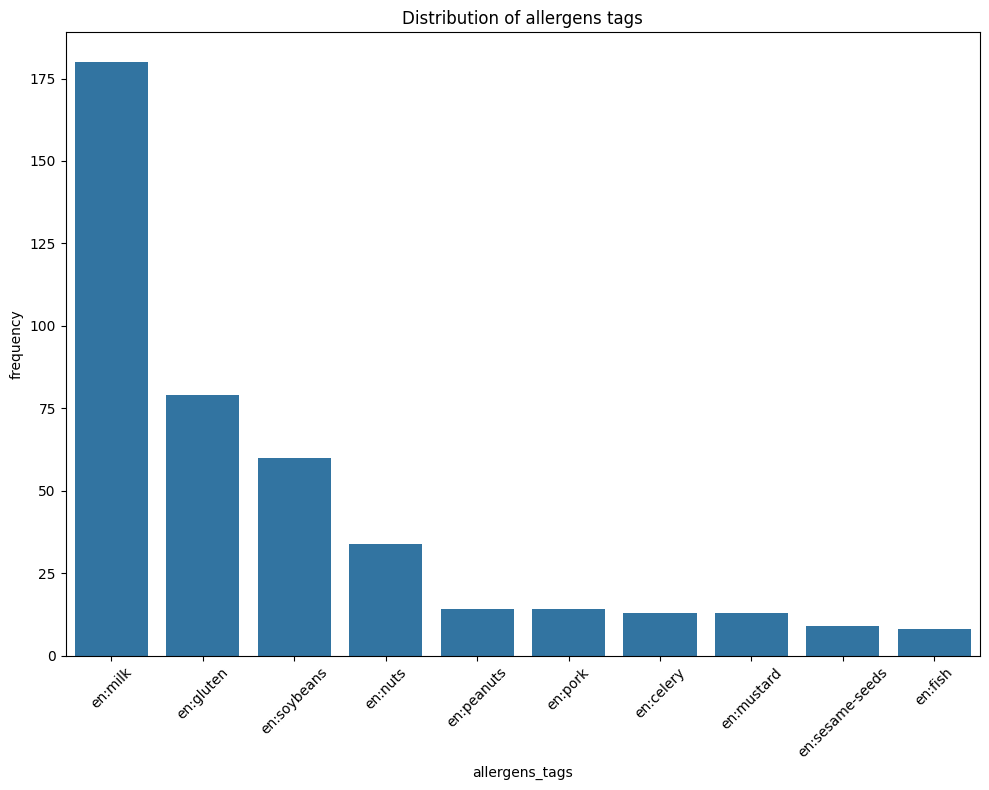

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

unique_values = final_df["allergens_tags"].unique
value_counts = final_df["allergens_tags"].value_counts()

indexvals=[",".join(i) for i in value_counts.index[:10]]
print(indexvals)
print(value_counts.values[:10])
plt.figure(figsize=(10,8))
sns.barplot(x=indexvals,y=value_counts.values[:10])
plt.xticks(rotation=45)
plt.xlabel("allergens_tags")
plt.ylabel("frequency")
plt.title("Distribution of allergens tags")
plt.tight_layout()
plt.show()


In [12]:
def get_image_url(product_data, image_name, resolution="full"):

    base_url = "https://images.openfoodfacts.org/images/products"
    # get product folder name
    folder_name = product_data["code"]
    print(folder_name)
    if len(folder_name) > 8:
        folder_name = re.sub(r'(...)(...)(...)(.*)', r'\1/\2/\3/\4', folder_name)
    # get filename
    if re.match("^\d+$", image_name):  # only digits
        # raw image
        resolution_suffix = "" if resolution == "full" else f".{resolution}"
        filename = f"{image_name}{resolution_suffix}.jpg"
    else:
        # selected image
        filename = f"{image_name}.{resolution}.jpg"
    # join things together
    return f"{base_url}/{folder_name}/{filename}"

os.makedirs(r"data/images",exist_ok=True)




# Download the images into a folder

In [17]:
'''
import requests
for ind, row  in final_df.iterrows():
    # barcode=final_df[final_df["images"]==item]["code"]
    for it in row["images"]:
        rev = int(it.get("rev", 0)) if it.get("rev") is not None else 0
        # if rev != 0:
        imagefile=str(it["key"])+"."+str(rev)
        image_url=get_image_url(product_data=row, image_name=imagefile, resolution="full")
        try:
            img_data = requests.get(image_url).content
            with open(f"data/images/{str(row['code'])}_{imagefile}.jpg", "wb") as img_file:
                img_file.write(img_data)
        except Exception as e:
            print(f"Error downloading {row['code']}: {e}")       
'''   


'\nimport requests\nfor ind, row  in final_df.iterrows():\n    # barcode=final_df[final_df["images"]==item]["code"]\n    for it in row["images"]:\n        rev = int(it.get("rev", 0)) if it.get("rev") is not None else 0\n        # if rev != 0:\n        imagefile=str(it["key"])+"."+str(rev)\n        image_url=get_image_url(product_data=row, image_name=imagefile, resolution="full")\n        try:\n            img_data = requests.get(image_url).content\n            with open(f"data/images/{str(row[\'code\'])}_{imagefile}.jpg", "wb") as img_file:\n                img_file.write(img_data)\n        except Exception as e:\n            print(f"Error downloading {row[\'code\']}: {e}")       \n'

In [8]:
with open("featuresnames.txt", "w") as f:
    f.write("\n".join("\t".join([ str(item), str(final_df[str(item)][0])]) for item in final_df.columns))

In [9]:
final_df.head(100).to_csv("findf.csv")

In [13]:
final_df["categories_tags"]

0       [en:breakfasts, en:spreads, en:sweet-spreads, ...
1                                               [en:null]
2       [en:plant-based-foods-and-beverages, en:bevera...
3       [en:beverages-and-beverages-preparations, en:p...
4                                                    None
                              ...                        
9995                                       [en:undefined]
9996                        [en:condiments, en:groceries]
9997                                       [en:undefined]
9998                                       [en:undefined]
9999                                       [en:undefined]
Name: categories_tags, Length: 10000, dtype: object

In [27]:
import pandas as pd

# Define the data as a list of dictionaries
data = [
    {"Column": "code", "Explanation": "Barcode: A unique product identifier (EAN code)."},
    {"Column": "brands", "Explanation": "Display name of the brand: 'Bovetti'."},
    {"Column": "brands_tags", "Explanation": "Machine-readable tag version of brand: 'xx:bovetti'."},
    {"Column": "product_name", "Explanation": "Product name in different languages (main & French): 'Véritable pâte à tartiner noisettes chocolat noir'."},
    {"Column": "generic_name", "Explanation": "Usually a simpler, common name. Here it's empty ([])."},
    {"Column": "quantity / product_quantity", "Explanation": "Net quantity (350 g)."},
    {"Column": "product_quantity_unit", "Explanation": "Unit of measure: grams (g)."},
    {"Column": "categories", "Explanation": "Human-readable hierarchy of food categories."},
    {"Column": "categories_tags", "Explanation": "Machine-readable tags (e.g. 'en:breakfasts', 'en:spreads')."},
    {"Column": "categories_properties", "Explanation": "Reference codes for food categories in databases like CIQUAL and Agribalyse."},
    {"Column": "compared_to_category", "Explanation": "Used for comparison (likely for EcoScore): 'en:cocoa-and-hazelnuts-spreads'."},
    {"Column": "food_groups_tags", "Explanation": "Higher-level group classification: ['en:sugary-snacks', 'en:sweets']."},
    {"Column": "packagings", "Explanation": "List of materials used (glass jar with metal lid)."},
    {"Column": "packaging_recycling_tags", "Explanation": "Recyclability info: 'en:recycle-in-sorting-bin'."},
    {"Column": "packaging_shapes_tags", "Explanation": "Shape info: 'en:jar', 'en:lid'."},
    {"Column": "packagings_complete", "Explanation": "True indicates packaging info is complete."},
    {"Column": "nutriments", "Explanation": "Detailed list of nutrients (e.g. fat, sugar, energy, proteins, etc.)."},
    {"Column": "nutriscore_grade", "Explanation": "Letter-based health grade (A to E): here, it's 'e' (least healthy)."},
    {"Column": "nutriscore_score", "Explanation": "Numeric score (higher is worse): 25.0."},
    {"Column": "nutrient_levels_tags", "Explanation": "Indicates high/low levels (e.g. fat and sugars high, salt low)."},
    {"Column": "labels", "Explanation": "Textual labels like 'Sans gluten' (gluten-free) and 'Sans huile de palme' (no palm oil)."},
    {"Column": "labels_tags", "Explanation": "Machine-readable version of labels."},
    {"Column": "allergens_tags", "Explanation": "Detected allergens: 'en:nuts'."},
    {"Column": "additives_n", "Explanation": "Number of additives (empty)."},
    {"Column": "additives_tags", "Explanation": "Additive tags (empty)."},
    {"Column": "traces_tags", "Explanation": "Possible trace allergens (empty)."},
    {"Column": "ingredients_text", "Explanation": "Raw ingredient list: empty here."},
    {"Column": "ingredients", "Explanation": "Parsed ingredient structure (empty)."},
    {"Column": "ingredients_tags", "Explanation": "Tags for known ingredients (empty)."},
    {"Column": "ingredients_analysis_tags", "Explanation": "Used for things like vegan/vegetarian status (empty)."},
    {"Column": "ingredients_from_palm_oil_n / with_sweeteners", "Explanation": "Specific ingredient count indicators—all empty or NaN."},
    {"Column": "countries_tags", "Explanation": "Country sold in: ['en:france']."},
    {"Column": "main_countries_tags / manufacturing_places_tags / origins_tags", "Explanation": "All empty – origin or manufacturing not specified."},
    {"Column": "ecoscore_grade", "Explanation": "Environmental impact score (missing here)."},
    {"Column": "ecoscore_score", "Explanation": "Numeric Eco-Score (missing)."},
    {"Column": "ecoscore_tags", "Explanation": "Lists 'd', which may relate to outdated scoring."},
    {"Column": "misc_tags", "Explanation": "Misc environmental indicators (e.g. missing origin, computed scores)."},
    {"Column": "images", "Explanation": "List of image metadata (front, ingredients, nutrition, etc.)."},
    {"Column": "photographers", "Explanation": "Empty here."},
    {"Column": "editors / creator / informers_tags / correctors_tags", "Explanation": "Contributors and community editors."},
    {"Column": "created_t", "Explanation": "Unix timestamp when product was created."},
    {"Column": "last_modified_t", "Explanation": "Last edit timestamp."},
    {"Column": "last_editor / last_modified_by", "Explanation": "Last person who edited: 'timotheeberthault'."},
    {"Column": "last_edit_dates_tags", "Explanation": "Human-readable last edit dates."},
    {"Column": "data_quality_info_tags", "Explanation": "Flags about missing packaging, environment score, or ingredient groupings."},
    {"Column": "data_quality_warnings_tags", "Explanation": "Warnings about environmental data missing or incomplete."},
    {"Column": "states_tags", "Explanation": "Product status – many aspects still incomplete (ingredients, origins, etc.)."},
    {"Column": "complete / completeness", "Explanation": "Status of completeness – 0.6875 implies about 69% complete."},
    {"Column": "obsolete", "Explanation": "False – product is current."},
    {"Column": "stores / stores_tags", "Explanation": "Not specified."},
    {"Column": "purchase_places_tags", "Explanation": "Empty."},
    {"Column": "popularity_tags", "Explanation": "High scan rank in 2024 – popular in user base."},
    {"Column": "unique_scans_n / scans_n", "Explanation": "Product scanned once."}
]

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv("product_metadata_explanation.csv", index=False)
